In [1]:
import sys
sys.path.append('..')

import optimus

frequency = 500e3 # 1MHz
a = 0.003 #3cm
D = 0.18 #18 cm
centroid_file='Data/default_random_array_centroid_locations.dat'
source = optimus.source.create_array(frequency, element_radius=a, centroid_locations_filename=centroid_file,
                                     location=[-D, 0, 0], number_of_point_sources_per_wavelength=2, velocity=0.4)

In [5]:
sphere_radius = 7.5e-3
geometry = optimus.geometry.shapes.Sphere(radius=7.5e-3, element_size=0.75e-3)
material_ext = optimus.material.load_material('muscle') #CAMBIE A MUSCULO POR ALPLA MUY BAJO EN WATER
material_int = optimus.material.load_material('bone (cortical)')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

x = source.centroid_locations[0, :]
y = source.centroid_locations[1, :]
z = source.centroid_locations[2, :]

In [2]:
import numpy as np
Nx = 201
Ny = 101
Nz = 101
# Zmax = 0.05 Nz=101 quizas menos
xmin, xmax, ymin, ymax, zmin, zmax = [-D, D, -0.05, 0.05, -0.05, 0.05]

In [ ]:
%%time

from optimus.source.transducers import transducer_field

paso = zmax / 50
save_p = []

for i in range(Nz):
    zval = (50 - i) * paso #PROBAR distintos valores loop (bajar valores de Nx Ny)
    plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
    points = np.vstack((plot_grid[0].ravel(),
                        plot_grid[1].ravel(),
                        zval*np.ones(plot_grid[0].size)))
    
    inc_field = transducer_field(source, material_ext, points, verbose=False)
    incident_pressure = inc_field.pressure.reshape([Nx, Ny])
    
    incident_pressure_plot = optimus.postprocess.common.array_to_imshow(incident_pressure)
    save_p.append(incident_pressure_plot)
    
    print(i)

In [7]:
zval = 0 #PROBAR distintos valores loop (bajar valores de Nx Ny)
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    zval*np.ones(plot_grid[0].size)))
    
inc_field = transducer_field(source, material_ext, points, verbose=False)
incident_pressure = inc_field.pressure.reshape([Nx, Ny])
    
incident_pressure_plot = optimus.postprocess.common.array_to_imshow(incident_pressure)

In [8]:
%%time
from optimus.source.transducers import transducer_field
inc_field = transducer_field(source, material_ext, points, verbose=True)
incident_pressure = inc_field.pressure.reshape([Nx, Ny])

Number of point sources across element diameter: 4
Number of point sources in transducer: 1024
Parallelisation library is: numba
CPU times: user 2min 33s, sys: 9.7 ms, total: 2min 33s
Wall time: 19.5 s


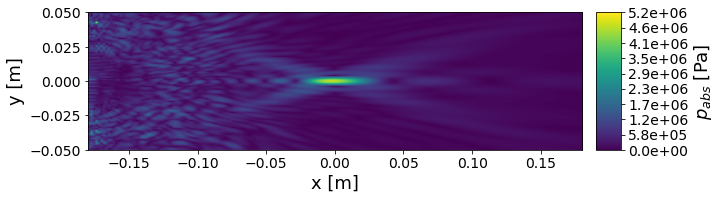

In [9]:
%matplotlib inline
from optimus.postprocess.plot import surface_plot

incident_pressure_plot = optimus.postprocess.common.array_to_imshow(incident_pressure)

theta = np.linspace(0, 2*np.pi, 100)
edge_sphere = (geometry.origin[0] + geometry.radius * np.cos(theta),
               geometry.origin[1] + geometry.radius * np.sin(theta))

fig = surface_plot(np.abs(incident_pressure_plot),
                   axes_lims=(xmin, xmax, ymin, ymax),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[0,np.max(np.abs(incident_pressure_plot))],
                   colorbar_unit="$p_{abs}$ [Pa]",
                   )

In [10]:
np.max(np.abs(incident_pressure_plot))

5219176.5581313865

In [11]:
c_0 = material_ext.speed_of_sound #bien
rho_0 = material_ext.density #bien
C_t = material_ext.heat_capacity #/ 1000 #DIVIDIRRRR
k_t = material_ext.thermal_conductivity
eta = material_ext.attenuation_pow_b #attenuation_pow_b
P = incident_pressure_plot.copy()
alpha_0 = material_ext.attenuation_coeff_a # Np/m
#alpha_0 = material_ext.attenuation_coeff_a * 8.69 # dB/m

In [12]:
I = (np.abs(P))**2 / (c_0 * rho_0)
alpha = alpha_0 * frequency / 1000000
Q = I.copy()
Q = 2 * alpha * I

Intensidad hasta 5000 W/cm$^2$ = 50000000 W/m$^2$

In [115]:
np.max(I) #orden correcta en w/m^2

15727145.40066334

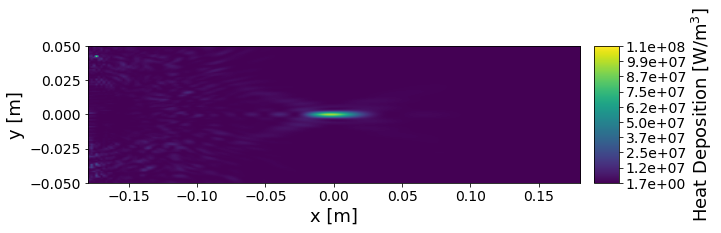

In [116]:
# PLOT Q
fig = surface_plot(np.abs(Q),
                   axes_lims=(xmin, xmax, ymin, ymax),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[np.min(Q),np.max(Q)],
                   colorbar_unit="Heat Deposition [W/m$^3$]",
                   )

In [13]:
delta_x = (xmax - xmin) / Nx
delta_y = (ymax - ymin) / Ny
delta_t = 1e-3

t_0 = 37

T_0 = np.zeros_like(Q) + t_0

aux = T_0.copy()

In [14]:
Q_aux = Q * delta_t / (rho_0 * C_t)

In [15]:
def next_it_numpy(T, Q):
    T_ret = np.zeros_like(T) + t_0
    A = 1 - 2 * delta_t * k_t / (rho_0 * C_t) * (delta_x ** (-2) + delta_y ** (-2))
    B = delta_t * k_t / (rho_0 * C_t) * (delta_x ** (-2))
    C = delta_t * k_t / (rho_0 * C_t) * (delta_y ** (-2))
    T_ret[1:Ny-1, 1:Nx-1] = (Q[1:Ny-1, 1:Nx-1] +
                             T[1:Ny-1, 1:Nx-1] * A +
                             (T[1:Ny-1, 0:Nx-2] + T[1:Ny-1, 2:Nx]) * B + 
                             (T[0:Ny-2, 1:Nx-1] + T[2:Ny, 1:Nx-1]) * C
                        )
    return T_ret

In [ ]:
%%time
Q_0 = np.zeros_like(Q)
temps = [T_0] #GUARDAR SOLO PUNTO EN LA MITAD 
N_t = 20000 #100 segundo
for i in range(N_t):
    temps.append(next_it_numpy(temps[-1], Q_aux))

In [151]:
np.max(temps)

62.66552286002305

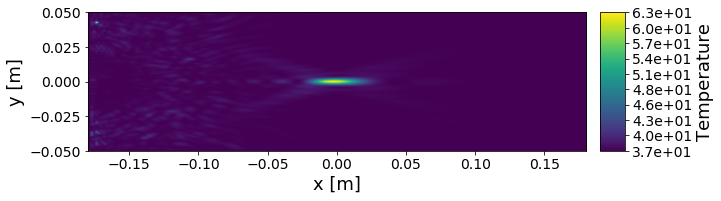

In [136]:
fig = surface_plot(temps[-1],
                   axes_lims=(xmin, xmax, ymin, ymax),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[37,np.max(temps)],
                   colorbar_unit="Temperature",
                   )

In [157]:
mid_x = Nx // 2
mid_y = Ny // 2

temps[-1][mid_y, mid_x]

temp_mid = [temp[mid_y, mid_x] for temp in temps]

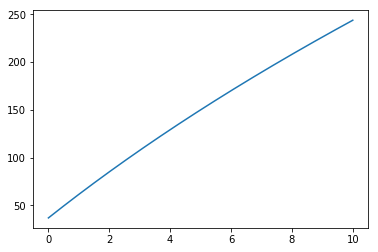

In [158]:
tiempos = np.arange(N_t + 1) * delta_t

plt.plot(tiempos, temp_mid)

# 3D

In [139]:
loaded_arr = np.loadtxt("IPP_abs.txt")

In [141]:
IPP_abs = loaded_arr.reshape(
    loaded_arr.shape[0], loaded_arr.shape[1] // 201, 201)

(101, 101, 201)

Poner solo un punto con toda la energía. Hacer iteraciones hasta llegar a temp cte.